# Analyse des courbes d'excitation électronique simple

Le bloc de code ci-dessous permet d'installer les modules requis à l'analyse.

In [76]:
# ! python.exe -m pip install --upgrade pip
# ! pip install -r requirements.txt

In [77]:
# Import des modules nécessaires
from outils_analyse.fits import gaussian_fit, gaus
from outils_analyse.identification_des_pics import determiner_indexes_maximums_scipy
from outils_analyse.lecture_des_fichiers import lire_csv_a_3_colonnes, crop_pour_conserver_que_la_partie_avec_rampe
from outils_analyse.conversion_temps_en_potentiel import calculer_facteur_conversion_temps_en_potentiel_avec_mesure_rampe
import matplotlib.pyplot as plt
import os
import matplotlib
import numpy as np
from sigfig import round
from ipywidgets import widgets, Layout

# Configuration de la taille de la police dans les figures
matplotlib.rcParams.update({'font.size': 18})

# Création du répertoire pour les graphiques s'il n'existe pas
out_dir = os.path.join("graphiques", "anal_profond")
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Désactivation des avertissements
import warnings
warnings.filterwarnings("ignore")

# Configuration de la palette de couleurs des graphiques
import seaborn as sns
palette = sns.color_palette("muted")
sns.color_palette("muted")

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

In [78]:
# Fonction pour sauvegarder le graphique avec confirmation
def save_with_confirmation(out_dir, name):
    # Vérifier si le fichier existe déjà
    file_path = os.path.join(out_dir, name + ".png")
    if os.path.exists(file_path):
        # Créer une boîte de dialogue de confirmation
        confirm = widgets.Button(description="Écraser le fichier existant ?", layout=Layout(width='200px'))
        display(confirm)

        # Fonction pour gérer la confirmation
        def on_confirm_click(b):
            # Supprimer le fichier existant
            os.remove(file_path)
            plt.savefig(file_path)
            print(f"Le fichier existant a été écrasé avec succès.")
            confirm.close()

        # Lier la fonction de confirmation au clic sur le bouton
        confirm.on_click(on_confirm_click)
    else:
        # Si le fichier n'existe pas, sauvegarder directement
        plt.savefig(file_path)
        print(f"Le fichier a été sauvegardé avec succès.")

## Copie de l'analyse légère pour un pic
> Remplacez votre chemin d'accès pour vos valeurs extraites à `file_name`.

> Modifier la valeur de `zero_threshold` au besoin.

> Si vous détectez des faux pics, augmentez la valeur de `distance_minimum`.

In [79]:
file_name = os.path.join("data", "excel", "Montage_B_step6.3.5_V4.5.csv")
valeurs_en_array = lire_csv_a_3_colonnes(file_name, 9)
valeurs_cropped_debutant_par_t0 = crop_pour_conserver_que_la_partie_avec_rampe(valeurs_en_array, 2,
    zero_threshold=0.007, infinity_threshold=0.1)

debut = min(valeurs_cropped_debutant_par_t0[:,0])
valeurs_cropped_debutant_par_t0[:,0] -= debut

facteur_conversion_temps_en_potentiel = calculer_facteur_conversion_temps_en_potentiel_avec_mesure_rampe(
    valeurs_cropped_debutant_par_t0, 0, 2)

valeurs_avec_bonnes_unites = valeurs_cropped_debutant_par_t0.copy()
valeurs_avec_bonnes_unites[:, 0] = -facteur_conversion_temps_en_potentiel[0] * valeurs_cropped_debutant_par_t0[:, 0] 

facteur_valeur = facteur_conversion_temps_en_potentiel[0]
facteur_incertitude = facteur_conversion_temps_en_potentiel[1]

liste_des_indexes_des_pics = determiner_indexes_maximums_scipy(valeurs_avec_bonnes_unites, 1,distance_minimum=200)

valeurs_avec_bonnes_unites_determination_des_pics = valeurs_avec_bonnes_unites[liste_des_indexes_des_pics]
liste_des_indexes_des_pics = liste_des_indexes_des_pics

## Régression gaussienne

In [80]:
def rounding_peaks(peaks, num_values=3, cutoff=5):
    rounded_values = [round(peaks[0][i], uncertainty=peaks[1][i], cutoff=cutoff) for i in range(num_values)]
    return rounded_values

pic_params = {}
start_index = []
end_index = []

num_pics_to_analyze = len(liste_des_indexes_des_pics)
pic_range = 50

for pic_index in range(num_pics_to_analyze):
    pic_start = liste_des_indexes_des_pics[pic_index] - pic_range
    start_index.append(pic_start)
    pic_end = liste_des_indexes_des_pics[pic_index] + pic_range
    end_index.append(pic_end)
    try:
        # Appliquer la fonction Gaussian Fit
        pic = gaussian_fit(
            valeurs_avec_bonnes_unites[pic_start:pic_end, 0],
            valeurs_avec_bonnes_unites[pic_start:pic_end, 1],
            valeurs_avec_bonnes_unites_determination_des_pics[pic_index, 1],
            valeurs_avec_bonnes_unites_determination_des_pics[pic_index, 0],
            1
        )

        pic_params[pic_index] = pic

    except RuntimeError as e:
        # En cas d'erreur, afficher un message et passer au pic suivant
        print(f"Erreur lors de l'ajustement du pic {pic_index + 1}: {e}\n")
        continue

# Afficher les valeurs pour chaque pic
threshold = 100
for pic_index, pic in pic_params.items():
    if np.any(pic[1] > 100):
        print(f"Pic {pic_index + 1} - Aucun fit gaussien n'est détecté à ce pic.\n")
    else:
        rounded_values = rounding_peaks(pic)
        amplitude, moyenne, std = rounded_values
        print(f"Pic {pic_index + 1} - Amplitude: {amplitude}\t Moyenne: {moyenne}\t STD: {std}\n")

Pic 1 - Amplitude: 0.1358 ± 0.0008	 Moyenne: 2.075 ± 0.004	 STD: 0.637 ± 0.005

Pic 2 - Amplitude: 0.643 ± 0.002	 Moyenne: 6.951 ± 0.004	 STD: 0.833 ± 0.005

Pic 3 - Amplitude: 1.308 ± 0.002	 Moyenne: 12.017 ± 0.002	 STD: 1.031 ± 0.003

Pic 4 - Amplitude: 1.7483 ± 0.0008	 Moyenne: 17.241 ± 0.001	 STD: 1.274 ± 0.002



## Calcul du potentiel de contact

In [81]:
# Calcul de l'écart moyen
ecarts = np.diff(valeurs_avec_bonnes_unites[liste_des_indexes_des_pics, 0])
ecart_moyen = np.mean(ecarts)
ecart_std = np.std(ecarts)

# Tensions et incertitudes
tension_u1 = 4.0
tension_u2 = valeurs_avec_bonnes_unites[liste_des_indexes_des_pics, 0][0]

incertitude_u1 = 0.01
incertitude_u2 = facteur_incertitude

# Calcul du potentiel de contact
potentiel_contact = tension_u1 + tension_u2 - ecart_moyen

# Calcul de l'incertitude du potentiel de contact
incertitude_potentiel_contact = np.sqrt(incertitude_u1**2 + incertitude_u2**2 + ecart_std**2)

## Graphique courants en fonction de la tension, emplacements approximatifs des maximums et fits gaussiens

Le fichier a été sauvegardé avec succès.
Taux de variation de la tension du générateur de rampe en fonction du temps : -0.44 ± 0.01 [V/s]
Estimation des pics : [ 2.168751  7.048439 12.018492 17.237047] [V]
Écart moyen entre chaque pic (V_res) : 5.0 ± 0.1 [V]
Potentiel de contact (W) : 1.1 ± 0.1 [V]


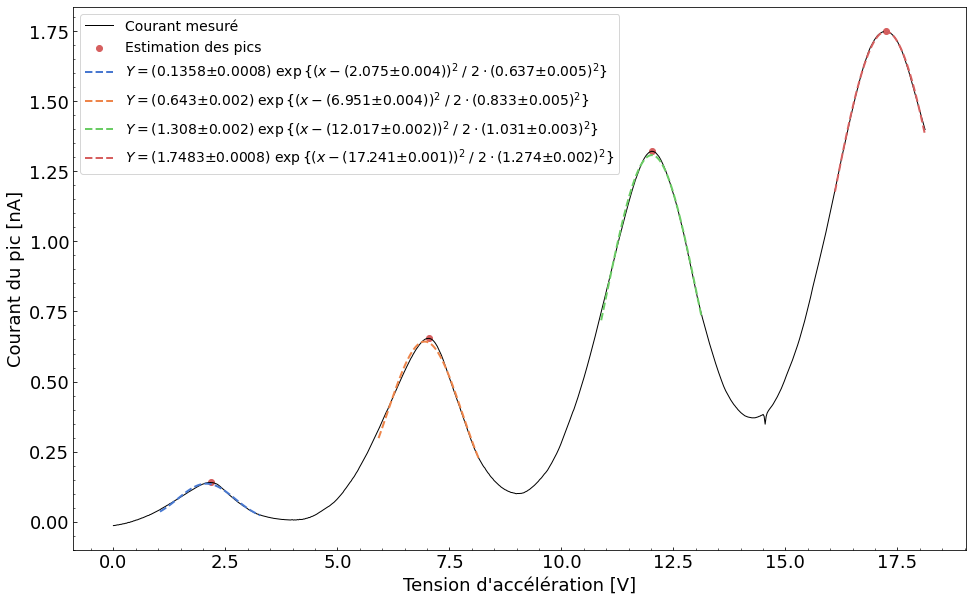

In [82]:
# Création de la figure
plt.figure(figsize=(16, 10))

# Tracé du courant mesuré
plt.plot(valeurs_avec_bonnes_unites[:, 0], valeurs_avec_bonnes_unites[:, 1], label="Courant mesuré",
        color="black", linewidth=1)

# Marquage des estimations de pics
plt.scatter(valeurs_avec_bonnes_unites[liste_des_indexes_des_pics, 0],
        valeurs_avec_bonnes_unites[liste_des_indexes_des_pics, 1],
        label="Estimation des pics", color=palette[3], marker='o')

for pic_index, pic in pic_params.items():
        if np.any(pic[1]>100):
                print(f"*Aucun fit gaussien n'est détecté pour le pic {pic_index+1}*")
        else:
                rounded_values = rounding_peaks(pic)
                plt.plot(valeurs_avec_bonnes_unites[start_index[pic_index]:end_index[pic_index],0],
                        gaus(valeurs_avec_bonnes_unites[start_index[pic_index]:end_index[pic_index],0],
                        pic[0][0], pic[0][1], pic[0][2]),
                label=f"$Y = ({rounded_values[0]})\;\exp\{{(x-({rounded_values[1]}))^2\; /\; 2\cdot({rounded_values[2]})^2\}}$",
                linestyle="dashed", color=palette[pic_index], linewidth=2)

# Configuration du graphique
plt.xlabel("Tension d'accélération [V]")
plt.ylabel("Courant du pic [nA]")
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='both', direction='in')
plt.minorticks_on()

name, _ = os.path.splitext(os.path.basename(file_name))

save_with_confirmation(out_dir, name)

# Affichage des informations
print(f"Taux de variation de la tension du générateur de rampe en fonction du temps : {round(facteur_valeur, facteur_incertitude)} [V/s]")
print(f"Estimation des pics : {valeurs_avec_bonnes_unites[liste_des_indexes_des_pics, 0]} [V]")
print(f"Écart moyen entre chaque pic (V_res) : {round(ecart_moyen, ecart_std)} [V]")
print(f"Potentiel de contact (W) : {round(potentiel_contact, incertitude_potentiel_contact)} [V]")

# Affichage du graphique
plt.show()